# Import necessary libraries and load the datasets#
Data Preprocessing and Merging the Datasets,
merging the transaction data with customer data

In [164]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

merged_df = transactions_df.merge(customers_df, on='CustomerID', how='left')

# Feature Engineering for Customer Profile and Transaction History#
Aggregating purchase information per customer

In [165]:
c_purchase_history = merged_df.groupby('CustomerID').agg(
    total_spent=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    total_transactions=pd.NamedAgg(column='TransactionID', aggfunc='nunique'),
    avg_transaction_value=pd.NamedAgg(column='TotalValue', aggfunc='mean')
).reset_index()

# Adding customer profile data (e.g., region)
cprofile = pd.merge(c_purchase_history, customers_df[['CustomerID', 'Region']], on='CustomerID')

# 3. Normalizing Features and preprocessing

In [166]:
#Onehotencoding Region column in region_encoded_df
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
region_encoded = encoder.fit_transform(cprofile[['Region']])
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))

# Removing Region column and concatinating the customer_profile and region_encoded
customers_profile = cprofile.drop('Region',axis=1)
customers_profile = pd.concat([customers_profile, region_encoded_df], axis=1)

In [167]:
#Applying Standardization
sc = StandardScaler()
sc_features = sc.fit_transform(customers_profile.drop('CustomerID', axis=1))

# 4. Clustering with KMeans #
Finding the optimal number of clusters using Elbow Method

In [168]:
inertia = []
silhouette_scores = []
db_indexes = []

for k in range(2, 40):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(sc_features)

    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(sc_features, kmeans.labels_))
    db_indexes.append(davies_bouldin_score(sc_features, kmeans.labels_))

 1. Plotting Elbow Method for Inertia

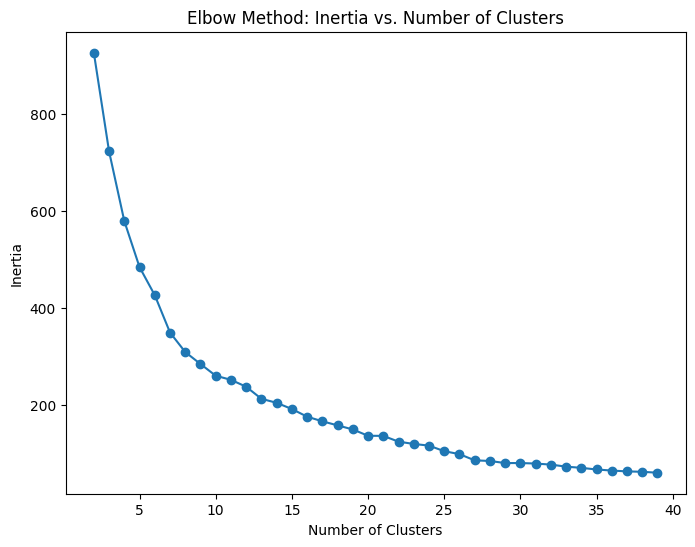

In [169]:
plt.figure(figsize=(8, 6))
plt.plot(range(2, 40), inertia, marker='o')
plt.title('Elbow Method: Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

2. Plotting Silhouette Scores

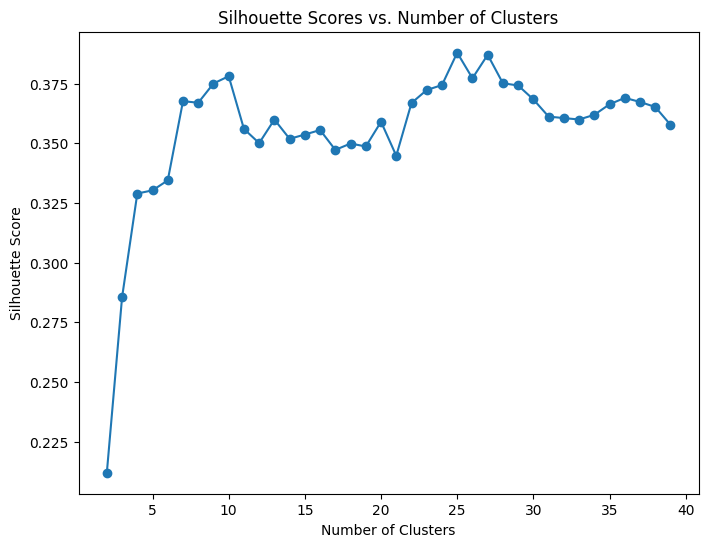

In [170]:
plt.figure(figsize=(8, 6))
plt.plot(range(2, 40), silhouette_scores, marker='o')
plt.title('Silhouette Scores vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

3. Plotting DB Index

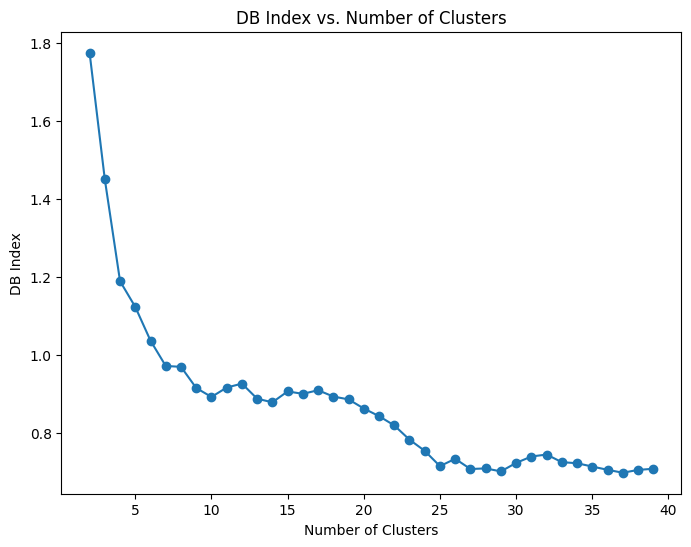

In [171]:
plt.figure(figsize=(8, 6))
plt.plot(range(2, 40), db_indexes, marker='o')
plt.title('DB Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()


# Choose optimal number of clusters #
4. Perform KMeans clustering with the optimal number of clusters

In [173]:
optimal_n = 25

kmeans = KMeans(n_clusters=optimal_n, random_state=42)
cprofile['Cluster'] = kmeans.fit_predict(sc_features)

5. Evaluating Clustering Performance

In [174]:
print(f'Optimal Number of Clusters: {optimal_n}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(sc_features, cprofile["Cluster"])}')
print(f'Silhouette Score: {silhouette_score(sc_features, cprofile["Cluster"])}')

Optimal Number of Clusters: 25
Davies-Bouldin Index: 0.7154081421112515
Silhouette Score: 0.38799270283464765


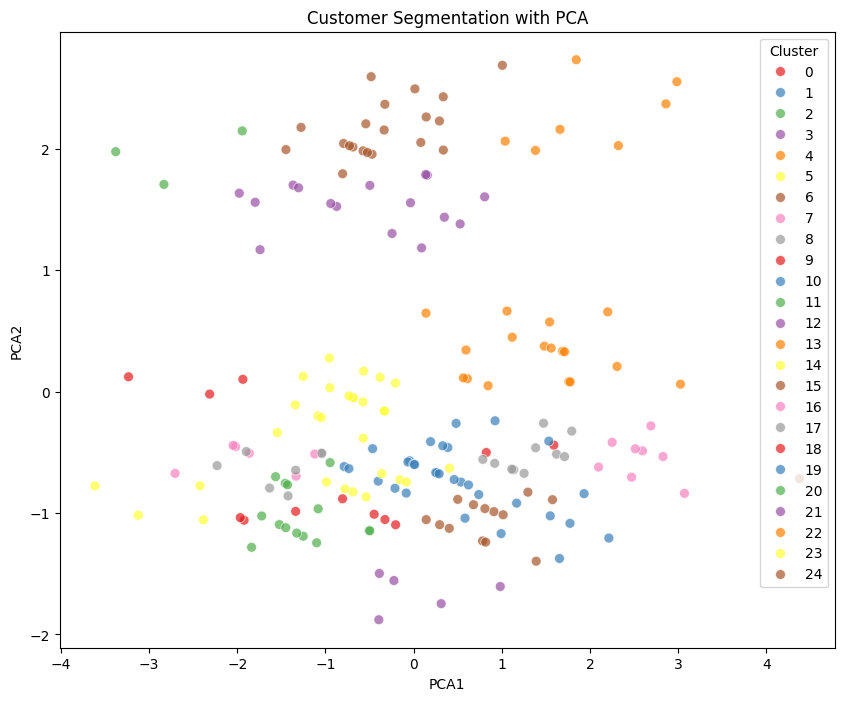

In [175]:
# 6. Visualizing the Clusters using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sc_features)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = cprofile['Cluster']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=50, alpha=0.7)
plt.title('Customer Segmentation with PCA')
plt.show()

7. Reporting the Results: Number of Clusters, DB Index, and other metrics

In [177]:
print(f"\nClustering Report:")
print(f"Number of clusters: {optimal_n}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(sc_features, cprofile['Cluster'])}")
print(f"Silhouette Score: {silhouette_score(sc_features, cprofile['Cluster'])}")


Clustering Report:
Number of clusters: 25
Davies-Bouldin Index: 0.7154081421112515
Silhouette Score: 0.38799270283464765


8. Saving the Final Clusters to a CSV File

In [178]:
cprofile.to_csv('Customer_Segmentation.csv', index=False)
print("\nCustomer Segmentation results saved to 'Customer_Segmentation.csv'.")


Customer Segmentation results saved to 'Customer_Segmentation.csv'.


In [179]:
df = pd.read_csv('Customer_Segmentation.csv')
print(df)

    CustomerID  total_spent  total_transactions  avg_transaction_value  \
0        C0001      3354.52                   5             670.904000   
1        C0002      1862.74                   4             465.685000   
2        C0003      2725.38                   4             681.345000   
3        C0004      5354.88                   8             669.360000   
4        C0005      2034.24                   3             678.080000   
..         ...          ...                 ...                    ...   
194      C0196      4982.88                   4            1245.720000   
195      C0197      1928.65                   3             642.883333   
196      C0198       931.83                   2             465.915000   
197      C0199      1979.28                   4             494.820000   
198      C0200      4758.60                   5             951.720000   

            Region  Cluster  
0    South America        1  
1             Asia        5  
2    South America   